In [1]:
import numpy as np
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn.metrics import roc_curve, auc, confusion_matrix

def escape():
    sys.exit()


Using TensorFlow backend.


# Data Preparation

In [2]:
import_directory = "./Database2/"
counter = 0
data_array = np.empty((0, 2))
files = os.listdir(import_directory)
for file in files:
    print('Opening File : ', file)
    data_set = np.load(import_directory+file, allow_pickle=True)
    data_array = np.vstack((data_array, data_set))

#separated = np.array([x for x in data_array if x[1] == 0])

Opening File :  destinationPayload_TestbedWedJun16-1Flows.xml.npy
Opening File :  destinationPayload_TestbedMonJun14Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-2Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-3Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-2Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-2Flows.xml.npy
Opening File :  destinationPayload_TestbedTueJun15-1Flows.xml.npy
Opening File :  destinationPayload_TestbedSunJun13Flows.xml.npy
Opening File :  destinationPayload_TestbedWedJun16-3Flows.xml.npy
Opening File :  destinationPayload_TestbedSatJun12Flows.xml.npy
Opening File :  destinationPayload_TestbedThuJun17-3Flows.xml.npy


In [6]:
np.random.seed(2019)
np.random.shuffle(data_array)
print("ok")

ok


In [7]:
img_row = 50
img_col = 50

N = np.shape(data_array)[0]
train_test_split_percentage = 0.75

X_train = data_array[:int(N * train_test_split_percentage), 0]
X_test = data_array[int(N * train_test_split_percentage):, 0]

X_train = np.array([x.reshape(img_row, img_col, 3) for x in X_train])
X_test = np.array([x.reshape(img_row, img_col, 3) for x in X_test])

In [8]:
y_train = data_array[:int(N * train_test_split_percentage), 1]
y_test = data_array[int(N * train_test_split_percentage):, 1]

y_train = np.array([[x] for x in y_train])
y_test = np.array([[x] for x in y_test])

In [9]:
print(X_train.shape, X_test.shape)

(602096, 50, 50, 3) (200699, 50, 50, 3)


(array([573567.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  28529.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

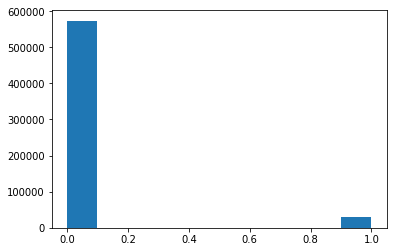

In [12]:
plt.hist(y_train.flatten())

(array([191145.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   9554.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

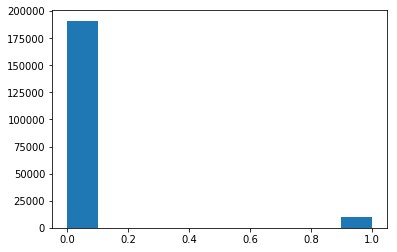

In [13]:
plt.hist(y_test.flatten())

In [43]:
573612+191100

764712

In [44]:
28484+9599

38083

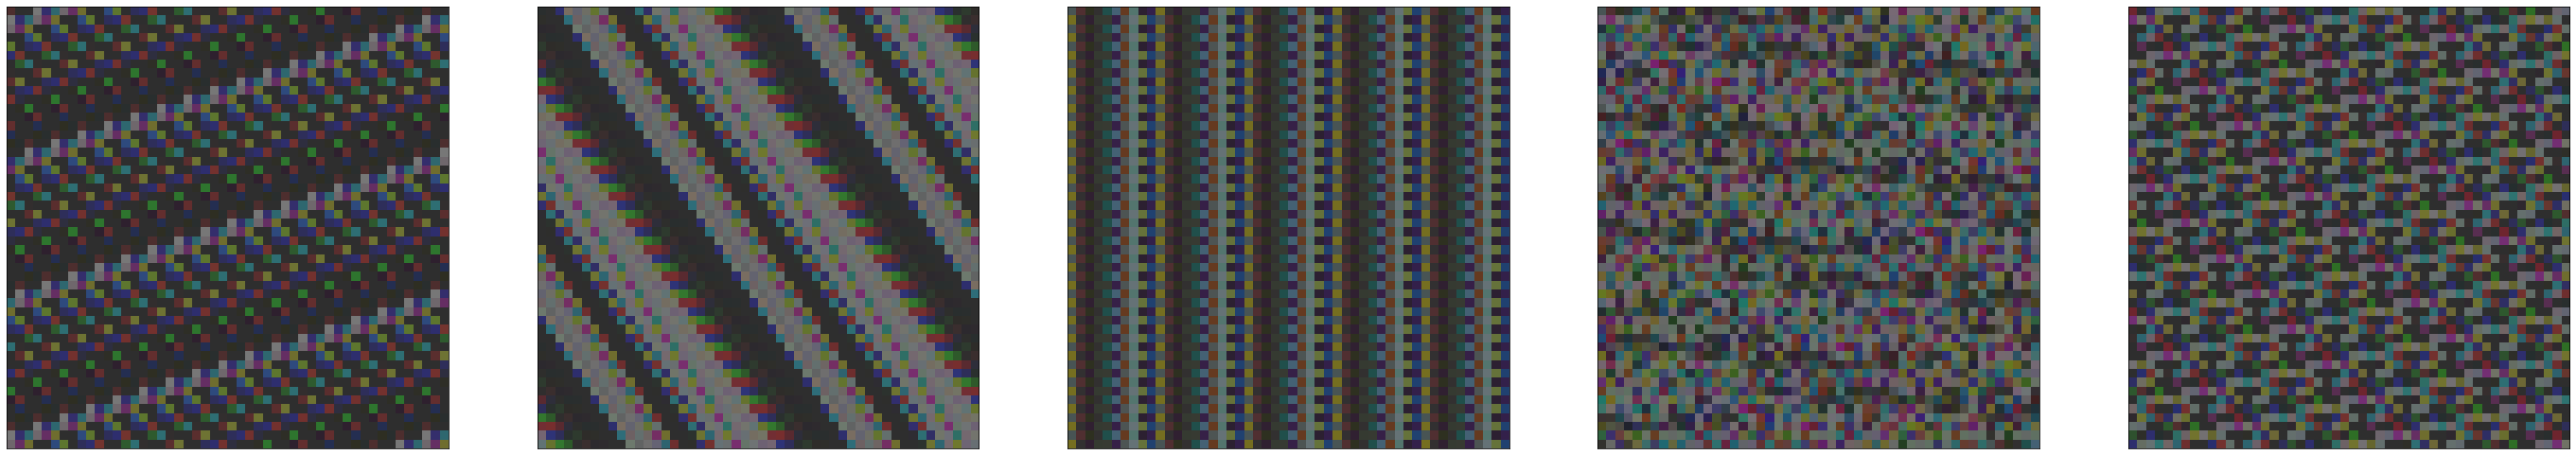

In [14]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(400, 150))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

## Data Augmentation

In [122]:
tmp = X_train[3]

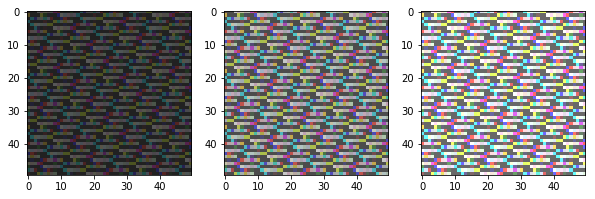

In [139]:
# example of brighting image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image

# convert to numpy array
#data = img_to_array(img)
data = tmp
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.2,1.6], fill_mode='reflect')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(3):
	# define subplot
	plt.subplot(130 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

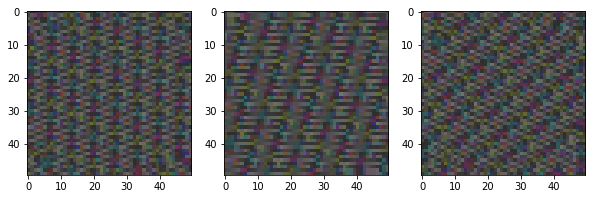

In [132]:
datagen = ImageDataGenerator(rotation_range=60, fill_mode='reflect')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(3):
	# define subplot
	plt.subplot(130 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

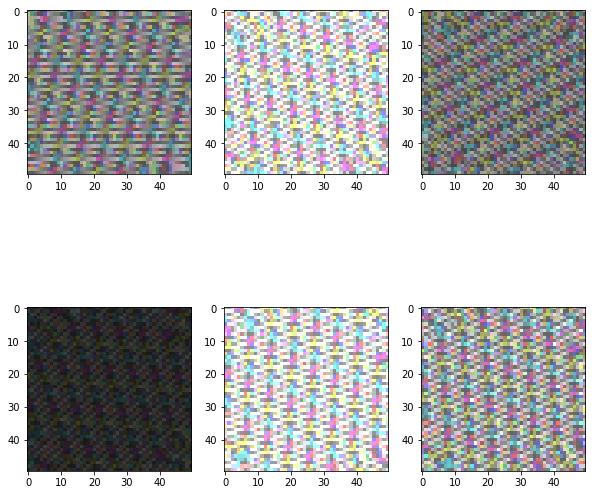

In [133]:
datagen = ImageDataGenerator(brightness_range=[0.2,1.6], rotation_range=45, fill_mode='reflect')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(10,10))
for i in range(6):
	# define subplot
	plt.subplot(230 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

Text(0.5, 1.0, 'After Data Augmentation')

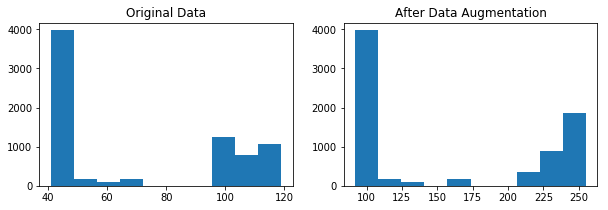

In [149]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(tmp.flatten())
plt.title('Original Data')

plt.subplot(122)
plt.hist(image.flatten())
plt.title('After Data Augmentation')

# Model Design

In [13]:
model_vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(img_col, img_row, 3))

# Freeze these layers for transfer learning
for layer in model_vgg16_conv.layers:
    layer.trainable = False
    print('Freezing: ', layer.name)

Freezing:  input_3
Freezing:  block1_conv1
Freezing:  block1_conv2
Freezing:  block1_pool
Freezing:  block2_conv1
Freezing:  block2_conv2
Freezing:  block2_pool
Freezing:  block3_conv1
Freezing:  block3_conv2
Freezing:  block3_conv3
Freezing:  block3_pool
Freezing:  block4_conv1
Freezing:  block4_conv2
Freezing:  block4_conv3
Freezing:  block4_pool
Freezing:  block5_conv1
Freezing:  block5_conv2
Freezing:  block5_conv3
Freezing:  block5_pool


In [98]:
# Plot model structure
keras.utils.plot_model(model, to_file='vgg16_proto.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [13]:
# Original VGG16
x = model_vgg16_conv.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(input=model_vgg16_conv.input, output=x)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


In [22]:
x = model_vgg16_conv.output
x = Flatten()(x)
x = keras.layers.Dropout(rate=0.4)(x)
x = Dense(256, activation='relu')(x)
x = keras.layers.Dropout(rate=0.4)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model_base = Model(input=model_vgg16_conv.input, output=x)
#model_base.summary()

/home/reck/anaconda2/envs/dev-reck-py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


In [9]:
512*4096

2097152

In [10]:
4096*4096

16777216

In [23]:
# Compile model for training
model_base.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 32
epochs = 3

# Training

In [24]:
hist = model_base.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = model_base.evaluate(X_test, y_test, verbose=0)

Train on 481676 samples, validate on 120420 samples
Epoch 1/3
481676/481676 [==============================] - 226s 469us/step - loss: 0.0563 - acc: 0.9887 - val_loss: 0.0474 - val_acc: 0.9907
Epoch 2/3
481676/481676 [==============================] - 223s 463us/step - loss: 0.0502 - acc: 0.9894 - val_loss: 0.0431 - val_acc: 0.9907
Epoch 3/3
481676/481676 [==============================] - 224s 464us/step - loss: 0.0513 - acc: 0.9891 - val_loss: 0.0535 - val_acc: 0.9907


#### AUC

In [ ]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

In [ ]:
rounded = [round(x) for x in y_pred_keras]

cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print(cm)
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

# Evaluation

In [30]:
model = model_base

In [21]:
hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=0)

Train on 481676 samples, validate on 120420 samples
Epoch 1/2
481676/481676 [==============================] - 228s 473us/step - loss: 0.0615 - acc: 0.9868 - val_loss: 0.0444 - val_acc: 0.9907
Epoch 2/2
481676/481676 [==============================] - 228s 474us/step - loss: 0.0616 - acc: 0.9867 - val_loss: 0.0741 - val_acc: 0.9526


In [46]:
hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = my_model.evaluate(X_test, y_test, verbose=0)

Train on 481676 samples, validate on 120420 samples
Epoch 1/2
481676/481676 [==============================] - 804s 2ms/step - loss: 0.0454 - acc: 0.9900 - val_loss: 0.0420 - val_acc: 0.9908
Epoch 2/2
481676/481676 [==============================] - 805s 2ms/step - loss: 0.0424 - acc: 0.9908 - val_loss: 0.0431 - val_acc: 0.9908


In [15]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04263567632483746
Test accuracy: 0.9906576515079796


## Plot loss curves

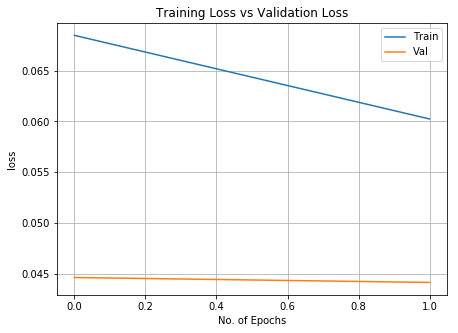

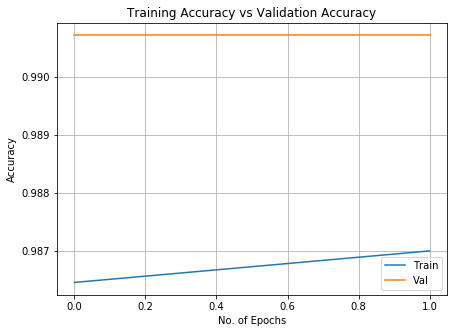

In [16]:
training_loss= hist.history['loss']
val_loss= hist.history['val_loss'] 
training_acc= hist.history['acc'] 
val_acc= hist.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5)) 
plt.plot(xc,training_loss)
plt.plot(xc,val_loss) 
plt.xlabel('No. of Epochs') 
plt.ylabel('loss') 
plt.title('Training Loss vs Validation Loss') 
plt.grid(True) 
plt.legend(['Train','Val'])

plt.figure(2,figsize=(7,5)) 
plt.plot(xc,training_acc) 
plt.plot(xc,val_acc) 
plt.xlabel('No. of Epochs') 
plt.ylabel('Accuracy') 
plt.title('Training Accuracy vs Validation Accuracy') 
plt.grid(True) 
plt.legend(['Train','Val'],loc=4)

total length =  200699
Anomolies =  9519
Normal =  191180


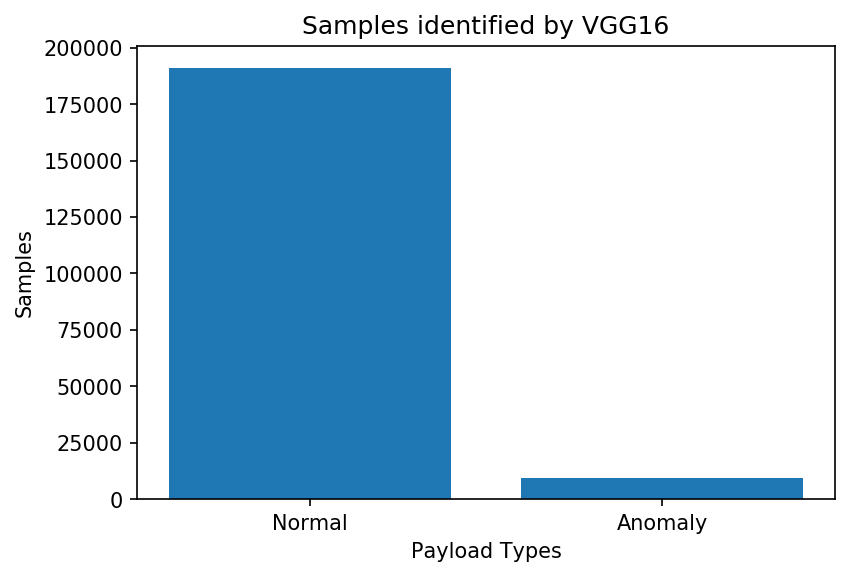

In [19]:
checking_occurences = [x for x in y_test if x == 1]
print("total length = ",len(y_test))
print("Anomolies = ",len(checking_occurences))
print("Normal = ", (len(y_test) - len(checking_occurences)))

n = len(y_test) - len(checking_occurences)
a = len(checking_occurences)

label = ['Normal', 'Anomaly']
samples = [n, a]

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi * 1.5

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, samples)
plt.xlabel('Payload Types', fontsize=10)
plt.ylabel('Samples', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title('Samples identified by VGG16')
plt.show()

In [20]:
predictions = my_model.predict(X_test)
print("Predictions = ",predictions)

Predictions =  [[6.2326164e-37]
 [0.0000000e+00]
 [1.9805348e-26]
 ...
 [8.6126769e-01]
 [8.6161697e-01]
 [5.7120176e-31]]


In [21]:
rounded = [[round(x[0])] for x in predictions]
from sklearn.metrics import f1_score
result = f1_score(y_test,rounded, average=None, labels = [0,1])
print("F1 = ",result)

F1 =  [0.99507855 0.90814677]


In [52]:
result = f1_score(y_test,rounded, average='macro')
print("F1 macro = ",result)

F1 macro =  0.9517051657706019


In [53]:
result = f1_score(y_test,rounded, average='micro')
print("F1 Micro= ",result)

F1 Micro=  0.9907274077100534


In [23]:
import sklearn.metrics
target_names = ['normal','anomaly']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00    191180
     anomaly       0.85      0.97      0.91      9519

    accuracy                           0.99    200699
   macro avg       0.92      0.98      0.95    200699
weighted avg       0.99      0.99      0.99    200699



In [24]:
result = f1_score(y_test,rounded, average='weighted')
print("F1 Weighted= ",result)

F1 Weighted=  0.9909554387257228


In [56]:
my_model.save("FYP_Finalhd5.hd5")
my_model.save("FYP_Finalh5.h5")

In [ ]:
from read_activations import get_activations, display_activations
v_index= 4
x_valid = X_train[:5]
a = get_activations(my_model, x_valid[v_index:v_index+1], print_shape_only=True)
display_activations(a)

## Different Headers (Classifiers)

### Header-1 (Prototype Model)

In [96]:
# del model
x = model_vgg16_conv.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
#x = keras.layers.Dropout(rate=0.4)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model_h1 = Model(inputs=model_vgg16_conv.input, outputs=x)

model = model_h1
# Compile model for training
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 64
epochs = 3

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

#### Training

In [89]:
hist_h1 = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
#score_h1 = model.evaluate(X_test, y_test, verbose=0)
model.save("ID_h1_final_ep3.hd5")

Train on 481676 samples, validate on 120420 samples
Epoch 1/3
481676/481676 [==============================] - 169s 351us/step - loss: 0.0552 - acc: 0.9892 - val_loss: 0.0416 - val_acc: 0.9910
Epoch 2/3
481676/481676 [==============================] - 169s 352us/step - loss: 0.0419 - acc: 0.9908 - val_loss: 0.0414 - val_acc: 0.9909
Epoch 3/3
481676/481676 [==============================] - 169s 351us/step - loss: 0.0420 - acc: 0.9908 - val_loss: 0.0423 - val_acc: 0.9910


In [61]:
score_h1

[0.041745589535275886, 0.9906576515109494]

#### AUC

In [93]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

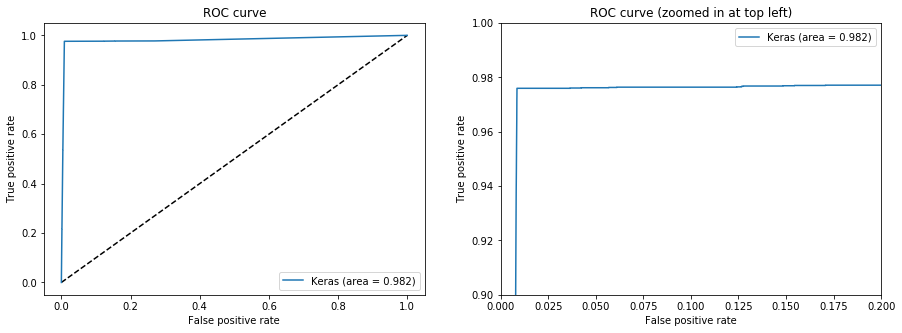

In [94]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

In [95]:
rounded = [round(x) for x in y_pred_keras]

cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print(cm)
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

[[189481   1645]
 [   230   9343]]
tn: 189481, fp 1645, fn 230, tp 9343
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    191126
   Malicious       0.85      0.98      0.91      9573

    accuracy                           0.99    200699
   macro avg       0.92      0.98      0.95    200699
weighted avg       0.99      0.99      0.99    200699



In [100]:
(tp+tn)/((tp+tn)+fp+fn)

0.9906576515079796

### Header-2

f(x) = alpha * x for x < 0,
f(x) = x for x >= 0,

In [114]:
# BatchNormalization, Parametric Rectified Linear Unit.
#del model
x = model_vgg16_conv.output
x = Flatten()(x)
x = keras.layers.Dropout(rate=0.4)(x)
x = Dense(256, activation=None)(x)
x = keras.layers.PReLU()(x)

x = keras.layers.Dropout(rate=0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model_h2 = Model(inputs=model_vgg16_conv.input, outputs=x)
#model_base.summary()

model = model_h2
# Compile model for training
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

batch_size = 64
epochs = 1

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

#### Training

In [115]:
hist_h2 = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
#score_h2 = model.evaluate(X_test, y_test, verbose=0)
model.save("ID_h2_final_bz64_ep3_adam.hdf5")

Train on 481676 samples, validate on 120420 samples
Epoch 1/1
481676/481676 [==============================] - 176s 366us/step - loss: 0.0899 - acc: 0.9866 - val_loss: 0.0432 - val_acc: 0.9909


#### AUC

In [116]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

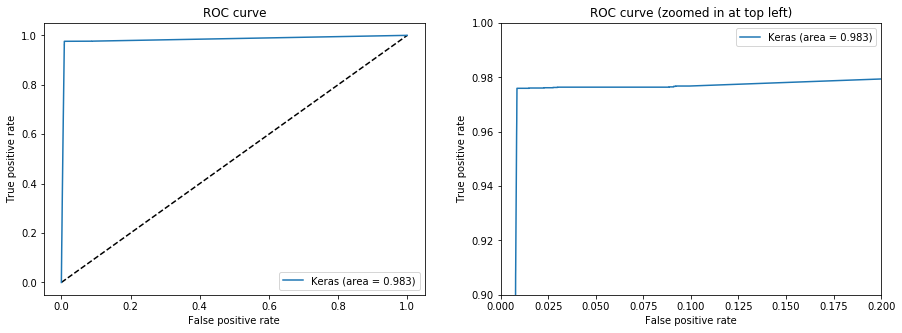

In [112]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

In [113]:
rounded = [round(x) for x in y_pred_keras]

cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print(cm)
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

[[189486   1640]
 [   236   9337]]
tn: 189486, fp 1640, fn 236, tp 9337
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00    191126
   Malicious       0.85      0.98      0.91      9573

    accuracy                           0.99    200699
   macro avg       0.92      0.98      0.95    200699
weighted avg       0.99      0.99      0.99    200699



In [119]:
(tp+tn)/((tp+tn)+fp+fn)

0.9906427037503924

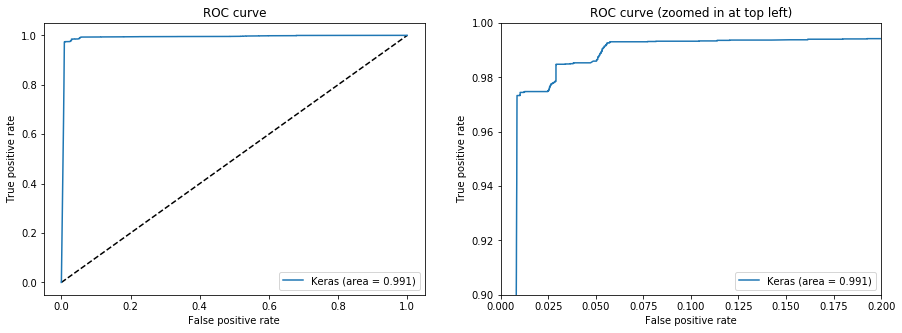

In [177]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')


# Zoom in view of the upper left corner.
plt.subplot(122)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')

In [72]:
rounded = [round(x) for x in y_pred_keras]

cm = confusion_matrix(y_test, rounded, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

print(cm)
print('tn: {:d}, fp {:d}, fn {:d}, tp {:d}'.format(tn, fp, fn, tp))
target_names = ['Normal','Malicious']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

[[189386   1740]
 [   240   9333]]
tn: 189386, fp 1740, fn 240, tp 9333
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    191126
   Malicious       0.84      0.97      0.90      9573

    accuracy                           0.99    200699
   macro avg       0.92      0.98      0.95    200699
weighted avg       0.99      0.99      0.99    200699

